# Rotating cylinders

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'png'

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import ibmos as ib

## Numerical grid and solver initialization

In [3]:
x = np.linspace(-1.40, 1.40, 129)
y = np.linspace(-1.40, 1.40, 129)

solver = ib.Solver(x, y, iRe=1.0, Co=0.75)

## Immersed boundaries

In [4]:
innerCyl = ib.shapes.cylinder("innerCyl", 0, 0, 0.5, solver.dxmin)
outerCyl = ib.shapes.cylinder("outerCyl", 0, 0, 1.0, solver.dxmin)

solver.set_solids(innerCyl, outerCyl)

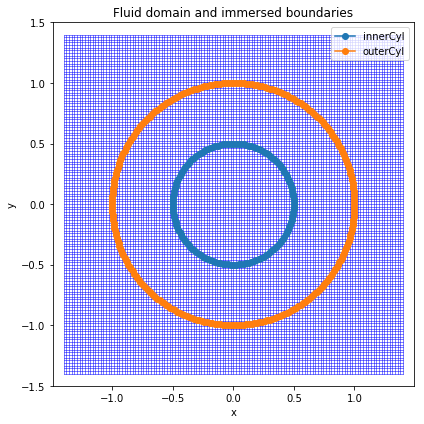

In [5]:
solver.plot_domain()

## Boundary conditions

In [6]:
fvBC = (lambda s, t: np.zeros_like(s),)*4
fuBC = (lambda s, t: np.zeros_like(s),)*4
fsBC = (( (lambda ξ, η, t: -2*η), (lambda ξ, η, t: 2*ξ)), (lambda ξ, η, t: np.zeros_like(ξ),)*2 )

## Steady simulation

In [7]:
x0, *_ = solver.steps(solver.zero(), fuBC, fvBC, fsBC, number=1, verbose=False)

In [8]:
uBC, vBC = solver.eval_uvBC(0, fuBC, fvBC)
sBC = solver.eval_sBC(0, fsBC)

In [9]:
%time x, infodict = solver.steady_state(x0, uBC, vBC, sBC, maxit=10, checkJacobian=True)

   k   residual_x   residual_f  innerCyl_fx  innerCyl_fy  outerCyl_fx  outerCyl_fy 
   1  2.47372e+00  1.61255e+00  2.08965e-09  2.08944e-09  1.47855e-07  1.47854e-07 
   2  1.65282e-01  2.59638e-03  1.50219e-09  1.47135e-09  1.05189e-07  1.05241e-07 
   3  7.92168e-05  2.87997e-10 -1.28253e-12 -8.28393e-13 -7.37312e-11 -7.46727e-11 
   4  5.58004e-08  9.96909e-16 -2.23821e-13  2.07445e-13  4.98268e-13 -3.92575e-13 
   5  2.35035e-11  9.42272e-16 -2.29150e-13  2.23155e-13  4.80505e-13 -4.36984e-13 
CPU times: user 47.7 s, sys: 4.23 s, total: 52 s
Wall time: 4.91 s


## Display results

Plot velocity components and pressure.

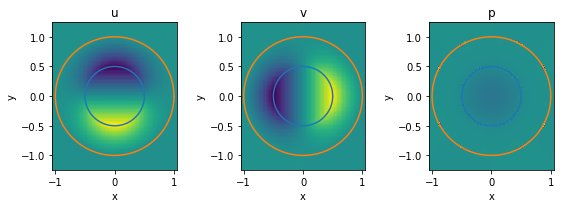

In [10]:
solver.plot_field(x, xlim=(-1, 1), ylim=(-1, 1))

Check results against analytical solution

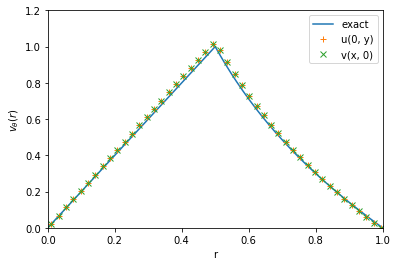

In [11]:
def vθ(r, w1, R1, R2):
    """Return azimuthal velocity."""
    if np.abs(r)<=R1:
        return w1*r
    elif R1<=np.abs(r)<=R2:
        return -R1**2*w1/(R2**2-R1**2)*r + w1/(R2**2-R1**2)*R1**2*R2**2/r
    else:
        return 0

u, v = solver.reshape(*solver.unpack(x))[:2]

r = np.linspace(0, 1, 257)
plt.plot(r, [-vθ(yk, -2.0, 0.5, 1.0) for yk in r], label='exact')
plt.plot(solver.fluid.u.y, -u[:, solver.fluid.u.shape[1]//2], '+', label='u(0, y)');
plt.plot(solver.fluid.v.x, v[solver.fluid.v.shape[0]//2], 'x', label='v(x, 0)');

plt.xlabel('r')
plt.ylabel('$v_θ(r)$')
plt.xlim(0, 1)
plt.ylim(0, 1.2)
plt.legend();

Show convergence history

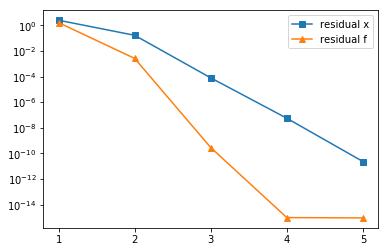

In [12]:
from matplotlib.ticker import MaxNLocator
k = np.arange(1, len(infodict['residual_x'])+1)
plt.semilogy(k, infodict['residual_x'], 's-', label='residual x')
plt.semilogy(k, infodict['residual_f'], '^-', label='residual f')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()